<a href="https://colab.research.google.com/github/G-Gaddu/Quant-Material/blob/main/Credit_Risk_Modelling_2_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import warnings
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from scipy import stats
import scipy.stats as stat
warnings.filterwarnings('ignore')

Loss Given Default and Exposure at Default

Load the data

In [ ]:
files.upload()

Saving loan_data_inputs_train.csv to loan_data_inputs_train.csv
Buffered data was truncated after reaching the output size limit.

In [ ]:
files.upload ()

Saving loan_data_inputs_test.csv to loan_data_inputs_test.csv
Buffered data was truncated after reaching the output size limit.

In [4]:
# Read the data and then combine the training and test data into one file
df1 = pd.read_csv('loan_data_inputs_train.csv', index_col = 0)
df2 = pd.read_csv('loan_data_inputs_test.csv', index_col = 0)
loan_data = pd.concat([df1, df2], axis = 0)

Data Preparation

In [5]:
# Keep only loans with status charged off or does not meet credit policy
loan_data_defaulted = loan_data[loan_data['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

In [6]:
# Check the dimensions
loan_data_defaulted.shape

(43236, 315)

In [7]:
# Fill NaN values in 'mths_since_last_delinq' and 'mths_since_last_record' with 0
loan_data_defaulted['mths_since_last_delinq'].fillna(0, inplace=True)
loan_data_defaulted['mths_since_last_record'].fillna(0, inplace=True)

In [8]:
# We define the recovert rate for each loan as the dependent variable. It is the ratio of the recovieries to the funded amount
loan_data_defaulted['recovery_rate'] = loan_data_defaulted['recoveries'] / loan_data_defaulted['funded_amnt']

In [9]:
# Calculate summary statistics for the recovery rate
recovery_rate_stats = loan_data_defaulted['recovery_rate'].describe()
recovery_rate_stats

,recovery_rate
count,43236.000000
mean,0.060820
std,0.089770
min,0.000000
25%,0.000000
50%,0.029466
75%,0.114044
max,1.220774


In [10]:
# Replace values greater than 1 with 1 and values less than 0 with 0 in the 'recovery_rate' column
loan_data_defaulted['recovery_rate'] = np.where(loan_data_defaulted['recovery_rate'] > 1, 1, loan_data_defaulted['recovery_rate'])
loan_data_defaulted['recovery_rate'] = np.where(loan_data_defaulted['recovery_rate'] < 0, 0, loan_data_defaulted['recovery_rate'])

In [11]:
# Calculcate the credit conversion factor which is given by funded amount - total received principal divided by funded amount
loan_data_defaulted['CCF'] = (loan_data_defaulted['funded_amnt'] - loan_data_defaulted['total_rec_prncp']) / loan_data_defaulted['funded_amnt']


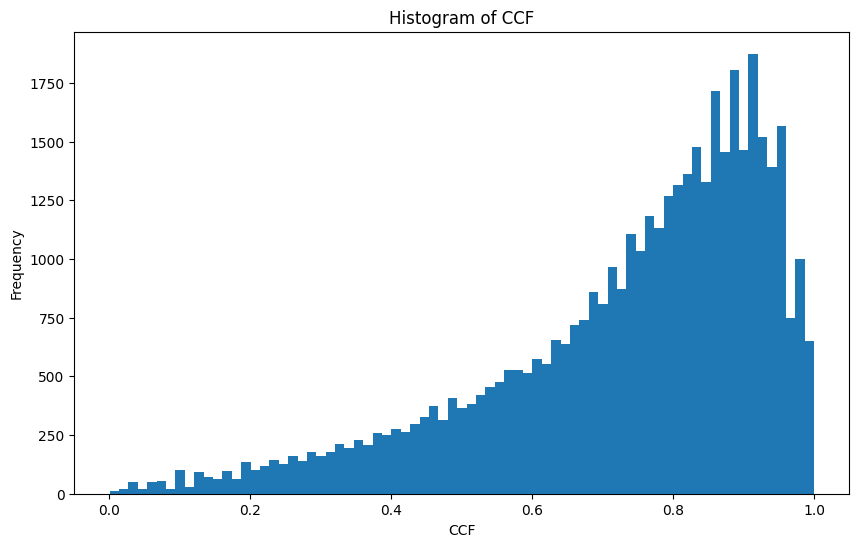

In [12]:
# Plot a histogram to find the distribution of the CCV
plt.figure(figsize=(10, 6))
plt.hist(loan_data_defaulted['CCF'], bins=75)
plt.xlabel('CCF')
plt.ylabel('Frequency')
plt.title('Histogram of CCF')
plt.show()


In [13]:
# Create a new column called recovery_rate_dummy which is 0 when the recovery rate is 0 and 1 otherwise
loan_data_defaulted['recovery_rate_dummy'] = np.where(loan_data_defaulted['recovery_rate'] == 0, 0, 1)

Loss GIven Default Model

In [14]:
log_X_data = loan_data_defaulted.drop(['recovery_rate', 'recovery_rate_dummy', 'CCF'], axis=1)
log_y_data = loan_data_defaulted['recovery_rate_dummy']

log_X_train, log_X_test, log_Y_train, log_Y_test = train_test_split(log_X_data, log_y_data, test_size = 0.2, random_state = 42)

In [15]:
# List all features for the model
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [16]:
# To avoid the dummy variable trap we list the following features
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [17]:
# Modify the training data
log_X_train = log_X_train[features_all]
log_X_train = log_X_train.drop(features_reference_cat, axis = 1)
log_X_train.isnull().sum()

,0
grade:A,0
grade:B,0
grade:C,0
grade:D,0
grade:E,0
grade:F,0
home_ownership:MORTGAGE,0
home_ownership:NONE,0
home_ownership:OTHER,0
home_ownership:OWN,0


In [18]:
# Create a class for the Logistic Regression model to provide the p values
class LogisticRegression_with_p_values:

    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]

        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [21]:
# Define and fit the model onto the training data
log_model1 = LogisticRegression_with_p_values()
log_model1.fit(log_X_train, log_Y_train)

In [22]:
# Get the name of the features for the summary table
feature_names = log_X_train.columns.values

In [23]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_names)
summary_table['Coefficients'] = np.transpose(log_model1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', log_model1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = log_model1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-8.110446e-05,NaN
1,grade:A,-1.784552e-05,9.998329e-01
2,grade:B,-6.595029e-05,9.992319e-01
3,grade:C,-1.249247e-04,9.984856e-01
4,grade:D,1.168440e-05,9.998636e-01
5,grade:E,3.166315e-05,9.996646e-01
6,grade:F,7.347781e-05,9.993250e-01
7,home_ownership:MORTGAGE,-4.543660e-05,9.985819e-01
8,home_ownership:NONE,1.285629e-06,9.999989e-01
9,home_ownership:OTHER,1.147937e-06,9.999979e-01


Testing the model

In [24]:
# Preprare the features data
log_X_test = log_X_test[features_all]
log_X_test = log_X_test.drop(features_reference_cat, axis = 1)

In [25]:
# Make predictions using the model
log_model_pred = log_model1.model.predict(log_X_test)

In [26]:
# Get the predicted probabilities
log_model_pred_proba = log_model1.model.predict_proba(log_X_test)

In [27]:
# Take only the probabilities for the prediction being 1
log_model_pred_proba = log_model_pred_proba[: ][: , 1]

In [28]:
# Create a table to show the values with the predicted probability
log_Y_test_temp = log_Y_test
log_Y_test_temp.reset_index(drop = True, inplace = True)
df_actual_predicted_probs = pd.concat([log_Y_test_temp, pd.DataFrame(log_model_pred_proba)], axis = 1)
df_actual_predicted_probs.columns = ['Target Value', 'Predicted Probability']
df_actual_predicted_probs.index = log_Y_test_temp.index
df_actual_predicted_probs.head()



,Target Value,Predicted Probability
0,1,0.439247
1,0,0.595124
2,0,0.617978
3,1,0.644188
4,0,0.674080


Determine the accuracy of the model

In [29]:
# Create a confusion matrix
tr = 0.5
df_actual_predicted_probs['log_model_pred'] = np.where(df_actual_predicted_probs['Predicted Probability'] > tr, 1, 0)
pd.crosstab(df_actual_predicted_probs['Target Value'], df_actual_predicted_probs['log_model_pred'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1203,2615
1,885,3945


Text(0.5, 1.0, 'ROC curve')

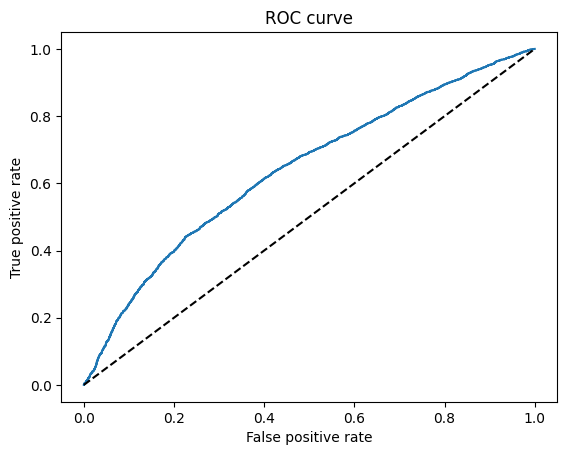

In [30]:
# Get the ROC Curve and the AUC
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['Target Value'], df_actual_predicted_probs['Predicted Probability'])
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [31]:
# Get the Area under the curve
AUROC = roc_auc_score(df_actual_predicted_probs['Target Value'], df_actual_predicted_probs['Predicted Probability'])
AUROC

0.6401888949261806

Linear Regression Modelling

In [32]:
lin_data = loan_data_defaulted[loan_data_defaulted['recovery_rate_dummy'] == 1]

lin_X_data = lin_data.drop([ 'recovery_rate','recovery_rate_dummy', 'CCF'], axis = 1)
lin_Y_data = lin_data['recovery_rate']
lin_X_train, lin_X_test, lin_Y_train, lin_Y_test = train_test_split(lin_X_data, lin_Y_data, test_size = 0.2, random_state = 42)

lin_X_train = lin_X_train[features_all]
lin_X_train = lin_X_train.drop(features_reference_cat, axis = 1)

In [33]:
# Create a class for the Linear Regression that incorporates the p values
class LinRegression(LinearRegression):
    def __init__(self, fit_intercept=True, copy_X=True, n_jobs=1):
        super().__init__(fit_intercept=fit_intercept, copy_X=copy_X, n_jobs=n_jobs)

    def fit(self, X, y):
        # Fit the model
        super().fit(X, y)

        # Get the number of samples and features
        n, p = X.shape

        # Predicted values
        y_pred = self.predict(X)

        # Calculate residuals
        residuals = y - y_pred

        # Sum of squared errors (SSE)
        sse = np.sum(residuals ** 2)

        # Estimate of variance (MSE)
        mse = sse / (n - p - 1)

        # Covariance matrix of the coefficients
        X_inv = np.linalg.inv(np.dot(X.T, X))
        cov_matrix = mse * X_inv

        # Standard errors of the coefficients
        se = np.sqrt(np.diagonal(cov_matrix))

        # t-statistics
        t_stat = self.coef_ / se

        # p-values
        p_values = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=n - p - 1))

        # Save the results
        self.t_stat = t_stat
        self.p_values = p_values

        return self

In [34]:
# Create and fit the model
lin_model1 = LinRegression()
# Estimating the coeffs w X_train and Y_train
lin_model1.fit(lin_X_train, lin_Y_train)

LinRegression()

In [35]:
# Create a table of the coefficients and their p values
feature_names2 = lin_X_train.columns.values
summary_table2 = pd.DataFrame(columns = ['Feature name'], data = feature_names2)
summary_table2['Coefficients'] = np.transpose(lin_model1.coef_)
summary_table2.index = summary_table2.index + 1
summary_table2.loc[0] = ['Intercept', lin_model1.intercept_]
summary_table2 = summary_table2.sort_index()
p_values = lin_model1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table2['p_values'] = p_values.round(3)

summary_table2


,Feature name,Coefficients,p_values
0,Intercept,2.596884e-01,NaN
1,grade:A,-8.542627e-02,0.000
2,grade:B,-6.188063e-02,0.000
3,grade:C,-4.839424e-02,0.000
4,grade:D,-3.485896e-02,0.000
5,grade:E,-1.903644e-02,0.000
6,grade:F,-1.049845e-02,0.029
7,home_ownership:MORTGAGE,2.436369e-03,0.101
8,home_ownership:NONE,1.435086e-01,0.000
9,home_ownership:OTHER,5.398011e-02,0.007


Evaluation

In [36]:
# Prepare the testing data and make predictions
lin_X_test = lin_X_test[features_all]
lin_X_test = lin_X_test.drop(features_reference_cat, axis = 1)

lin_X_test.columns.values



array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [37]:
lin_preds = lin_model1.predict(lin_X_test)
lin_Y_test_temp = lin_Y_test
lin_Y_test_temp = lin_Y_test_temp.reset_index(drop = True)

# Calculating the correlation between actual and predicted values.
pd.concat([lin_Y_test_temp, pd.DataFrame(lin_preds)], axis = 1).corr()



,recovery_rate,0
recovery_rate,1.000000,0.286862
0,0.286862,1.000000


<Axes: xlabel='recovery_rate', ylabel='Density'>

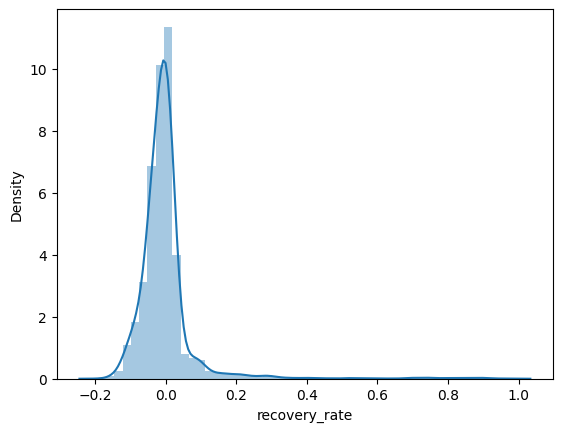

In [38]:
# Plot the distribution of the residuals
sns.distplot(lin_Y_test_temp - lin_preds)

In [39]:
# Make predictions using the model
final_preds = lin_model1.predict(log_X_test)
final_preds

array([0.1663549 , 0.12969876, 0.11177816, ..., 0.13482666, 0.10030066,
       0.10221578])

In [40]:
# Combine the predictions of both models
values = log_model_pred * final_preds
values

array([0.        , 0.12969876, 0.11177816, ..., 0.13482666, 0.10030066,
       0.10221578])

In [41]:
# Get the summary stats
values_df = pd.DataFrame(values, columns=['Values'])
print(values_df.describe())

            Values
count  8648.000000
mean      0.081082
std       0.052044
min      -0.004608
25%       0.031443
50%       0.097587
75%       0.120525
max       0.240395


In [42]:
# Set values greater than 1 to 1 and less than 0 to 0
values_df = np.where(values_df < 0, 0, values_df)
values_df = np.where(values_df > 1, 1, values_df)
pd.DataFrame(values_df).describe()

,0
count,8648.000000
mean,0.081083
std,0.052042
min,0.000000
25%,0.031443
50%,0.097587
75%,0.120525
max,0.240395


Exposure at Default Model - Predicted amount of loss that an insitution is exposed to

In [43]:
# Prepare the data
ead_X = loan_data_defaulted.drop([ 'recovery_rate','recovery_rate_dummy', 'CCF'], axis = 1)
ead_Y = loan_data_defaulted['CCF']
ead_X_train, ead_X_test, ead_Y_train, ead_Y_test = train_test_split(ead_X, ead_Y, test_size = 0.2, random_state = 42)
ead_X_train.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [44]:
ead_X_train = ead_X_train[features_all]
ead_X_train = ead_X_train.drop(features_reference_cat, axis = 1)

lin_model2 = LinRegression()
lin_model2.fit(ead_X_train, ead_Y_train)

LinRegression()

In [45]:
feature_name3 = ead_X_train.columns.values

summary_table3 = pd.DataFrame(columns = ['Feature name'], data = feature_name3)
summary_table3['Coefficients'] = np.transpose(lin_model2.coef_)
summary_table3.index = summary_table3.index + 1
summary_table3.loc[0] = ['Intercept', lin_model2.intercept_]
summary_table3 = summary_table3.sort_index()
p_values = lin_model2.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table3['p_values'] = p_values
summary_table3



,Feature name,Coefficients,p_values
0,Intercept,1.093109e+00,NaN
1,grade:A,-2.894280e-01,0.000000e+00
2,grade:B,-2.244236e-01,0.000000e+00
3,grade:C,-1.633793e-01,0.000000e+00
4,grade:D,-1.130644e-01,0.000000e+00
5,grade:E,-6.468983e-02,0.000000e+00
6,grade:F,-1.992519e-02,4.858091e-03
7,home_ownership:MORTGAGE,-6.689340e-03,1.416008e-03
8,home_ownership:NONE,2.396226e-02,7.533552e-01
9,home_ownership:OTHER,2.162196e-04,9.944751e-01


Model Validation

In [46]:
# Prepare the testing data
ead_X_test = ead_X_test[features_all]
ead_X_test = ead_X_test.drop(features_reference_cat, axis = 1)

In [47]:
ead_X_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [48]:
# Make predictions using our model and evaluate them
y_hat_test_ead = lin_model2.predict(ead_X_test)
ead_Y_test_temp = ead_Y_test
ead_Y_test_temp = ead_Y_test_temp.reset_index(drop = True)
pd.concat([ead_Y_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.519019
0,0.519019,1.000000


<Axes: xlabel='CCF', ylabel='Density'>

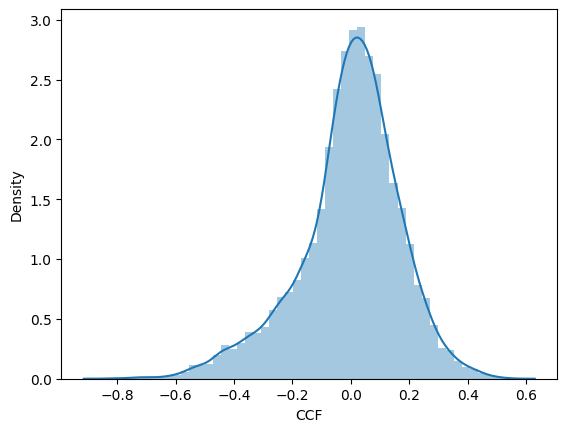

In [49]:
# Plot the residuals
sns.distplot(ead_Y_test - y_hat_test_ead)

In [50]:
# Descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736497
std,0.104487
min,0.385745
25%,0.663073
50%,0.732534
75%,0.810746
max,1.008400


In [51]:
# Setting predicted values that are greater than 1 to 1 and vice versa
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)
pd.DataFrame(y_hat_test_ead).describe()



,0
count,8648.000000
mean,0.736496
std,0.104484
min,0.385745
25%,0.663073
50%,0.732534
75%,0.810746
max,1.000000
